Лабораторная работа 2

Будникова Валерия Павловна 

группа: М8О-407Б-19

In [1]:
import torch, torchvision
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm

In [2]:
import cv2
import numpy as np
from torchvision.datasets import VOCSegmentation

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)


VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]


class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        image,mask = torchvision.transforms.functional.to_tensor(image), torch.from_numpy(mask)
        mask = mask.permute(2,0,1)
        return image, mask

In [3]:
from albumentations import Compose, RandomBrightnessContrast, RandomCrop, Flip, RandomSizedCrop, OneOf, PadIfNeeded

In [4]:
augs = Compose([
                 PadIfNeeded(448,448),
                 RandomBrightnessContrast(),
                 OneOf([
                        RandomCrop(256,256, p=0.2),
                        RandomSizedCrop((224,448),256,256)
                 ], p =1)
])

In [5]:
train_dataset = PascalVOCSearchDataset('.',download = True, transform = augs)


  0%|          | 0/1999639040 [00:00<?, ?it/s]

Extracting ./VOCtrainval_11-May-2012.tar to .


In [6]:
train_dataset[0][1].shape

torch.Size([21, 256, 256])

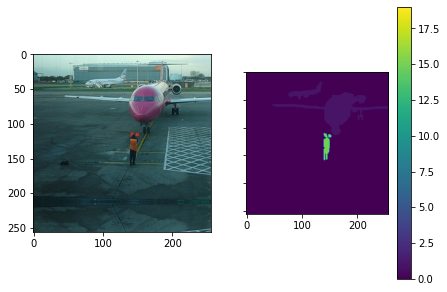

In [7]:
img,lbl = train_dataset[0]
fig,ax = plt.subplots(1,2, sharey=True, figsize=(7,5))
ax = ax.ravel()

ax[0].imshow(img.permute(1,2,0))
lbl_plot = ax[1].imshow(lbl.argmax(0),vmax = 19)
plt.colorbar(lbl_plot,ax = ax[1])
plt.show()

In [8]:
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large

In [9]:
flag = False
if flag:
  model = deeplabv3_mobilenet_v3_large(True, num_classes = len(VOC_CLASSES), progress = True)
else:
  model = torch.load('/content/model.pkl')


In [10]:
optim = torch.optim.AdamW(model.parameters(), lr = 3e-5, weight_decay = 1e-5)

In [11]:
dataloader = DataLoader(train_dataset, batch_size = 8, shuffle = True, num_workers = 2)

In [12]:
crit = torch.nn.CrossEntropyLoss(label_smoothing = 1e-5)

In [13]:
model.cuda()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride

In [14]:
from IPython.core.interactiveshell import io_open

if flag: #Если обученная модель уже загружена, то обучение не происходит
  r_losses = []
  v_losses = []
  rloss = 0
  vloss = 0
  next_desc = "first epoch"

  train_size = int(0.8 * len(train_dataset))
  val_size = len(train_dataset) - train_size

  for epoch in range(7):
    
    train, val = torch.utils.data.random_split(train_dataset, [train_size, val_size])
    train_dataloader = DataLoader(train, batch_size = 8, shuffle = True, num_workers = 2)
    val_dataloader = DataLoader(val, batch_size = 8, shuffle = True, num_workers = 2)

    for img,lbl in tqdm(train_dataloader, desc = next_desc):
      img = img.cuda()
      lbl = lbl.cuda()
      predict = model(img)['out']
      loss = crit(predict, lbl)
      loss.backward()
      optim.step()
      optim.zero_grad()
      rloss += loss.detach().cpu().item() / len(train_dataloader)
    for img,lbl in val_dataloader:
      img = img.cuda()
      lbl = lbl.cuda()
      predict = model(img)['out']
      loss = crit(predict, lbl)
      vloss += loss.detach().cpu().item() / len(val_dataloader)
    r_losses+= [rloss]
    v_losses+= [vloss]
    next_desc = f"Epoch: [{epoch+1}], previous rloss: [{rloss:.3f}], previous vloss: [{vloss:.3f}]"
    rloss = 0
    vloss = 0
  plt.plot(r_losses, 'b')
  plt.plot(v_losses, 'r')

In [16]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train, val = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_dataloader = DataLoader(train, batch_size = 8, shuffle = True, num_workers = 2)
val_dataloader = DataLoader(val, batch_size = 8, shuffle = True, num_workers = 2)

In [17]:
# torch.save(model, 'model.pkl')

In [18]:
def IoU(lbl, pred, fl = False):
  overleap = 2 * pred * lbl / (pred + lbl)
  overleap = torch.nan_to_num(overleap, nan=0.0)
  union = lbl + pred - overleap

  rez = (torch.count_nonzero(overleap).item() + 1) / (torch.count_nonzero(union).item() + 1)

  if fl:
    fig,axes = plt.subplots(1, 4, figsize = (12, 5))
    axes[0].imshow(lbl)
    axes[0].set_title("label")
    axes[1].imshow(pred)
    axes[1].set_title("pred")
    axes[2].imshow(overleap)
    axes[2].set_title("overleap")
    axes[3].imshow(union)
    axes[3].set_title("union")
  return rez
    

def IoU_batch(lab, pred, fl = False):

  v = lab.argmax(1)
  v2 = torch.nn.functional.one_hot(v, 21)
  v3 = torch.permute(v2, (0, 3, 1, 2))
  
  list_rez = np.empty((len(lab), 21))
  for k in range(len(lab)):
    rez = np.zeros(21)
    for j in range(21):
      pr = torch.zeros_like(pred[k])

      a = pred[k].argmax(0)
      b1 = torch.ones_like(a) * j
      b = a == b1
      rez[j] = IoU(v3[k][j], b, fl)
    list_rez[k] = rez.tolist()
  return list_rez 

def MIoU(iou):
  return sum(iou)/len(iou)

def MIoU_batch(lab, pred):
  l_iou = IoU_batch(lab, pred)
  rez = []
  for i in l_iou:    
    rez += [MIoU(i)]
  return rez 
  
def MIoU_batch_i(iou):
  rez = []
  for i in iou:    
    rez += [MIoU(i)]
  return rez 

Метрика iou и miou

<ipython-input-18-20901384d049>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,axes = plt.subplots(1, 4, figsize = (12, 5))


iou: 
 [0.92811119 1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.79322508 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.        ]
miou:  0.9867302988155014


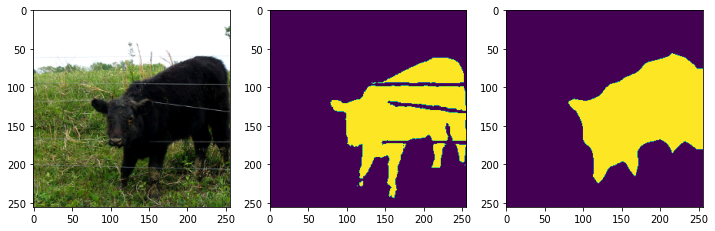

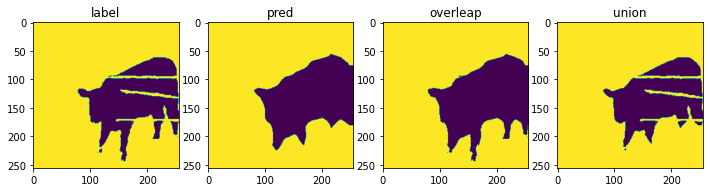

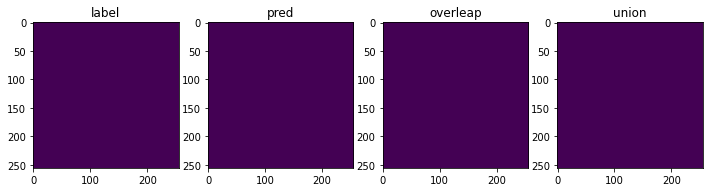

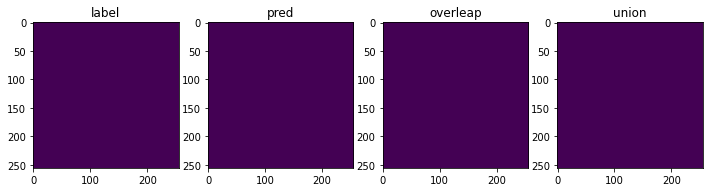

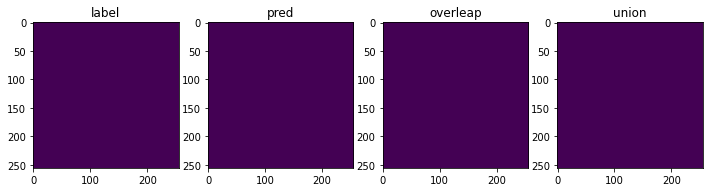

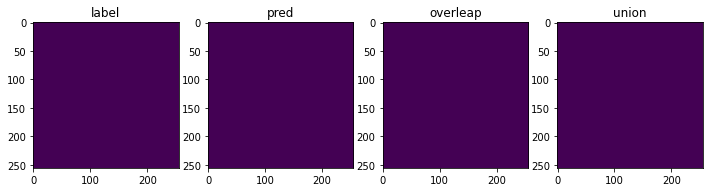

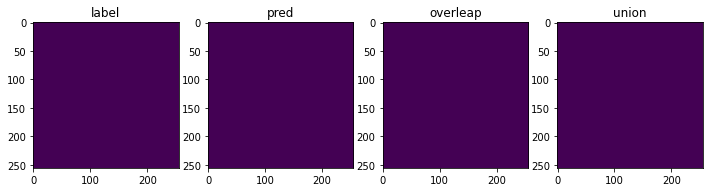

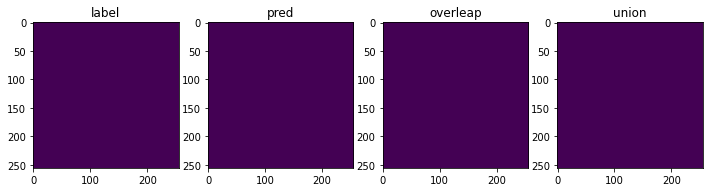

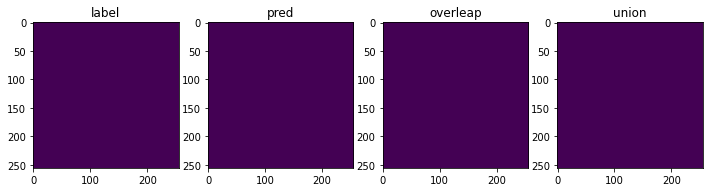

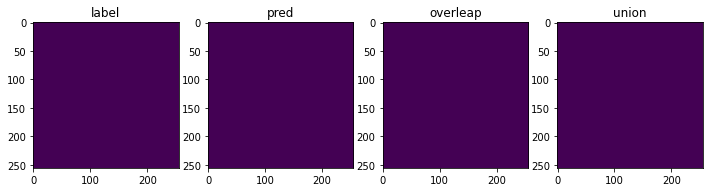

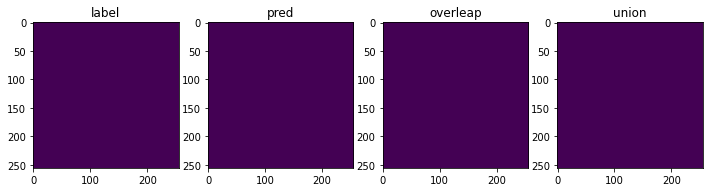

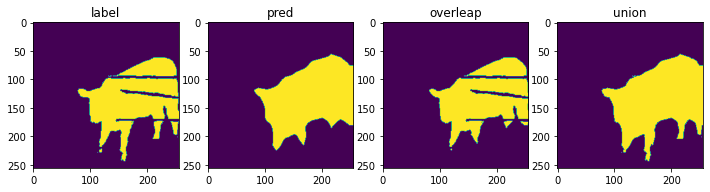

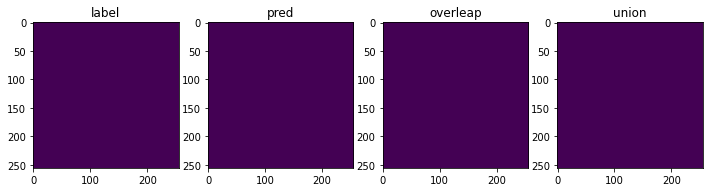

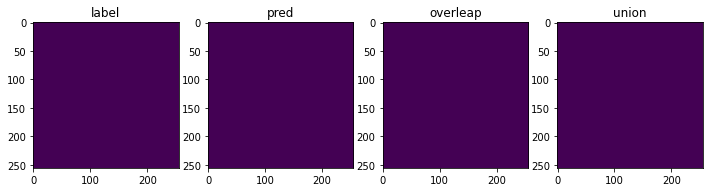

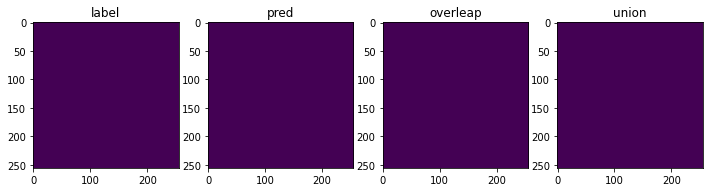

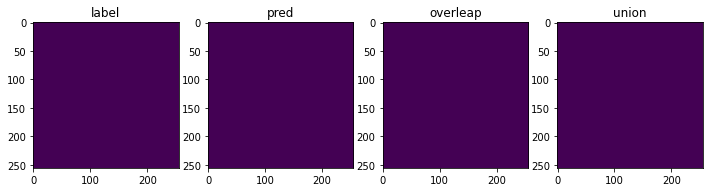

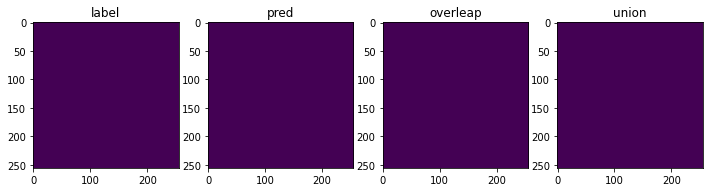

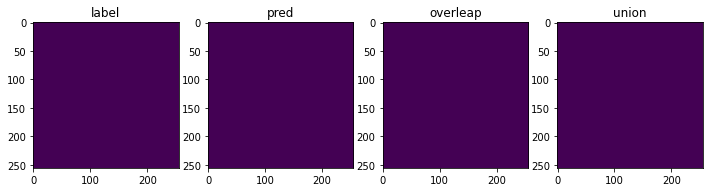

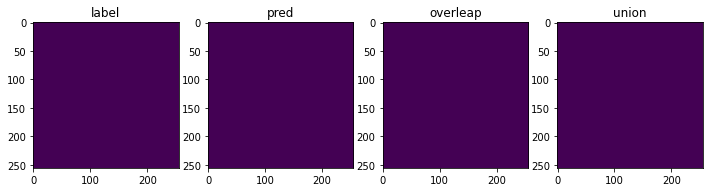

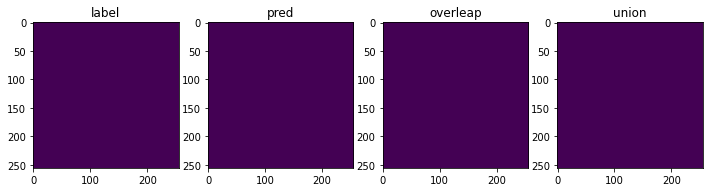

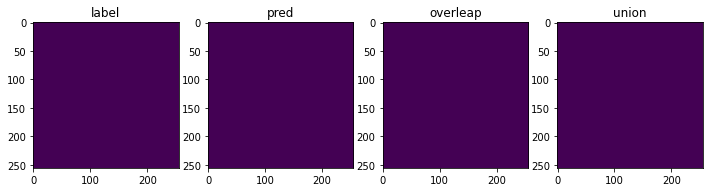

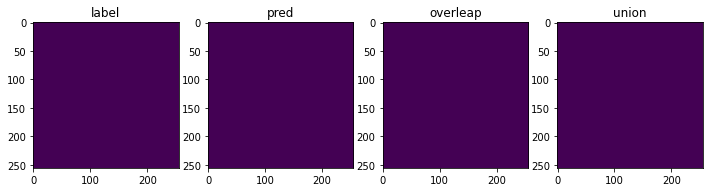

In [19]:
for img, lbl in val_dataloader:
    img = img.cuda()
    lbl = lbl.cuda()
    predict = model(img)['out']
    pr = predict.detach().cpu()
    l = lbl.detach().cpu()
    fig,axes = plt.subplots(1, 3, figsize = (12, 5))
    axes[0].imshow(img[0].detach().cpu().permute(1,2,0))
    axes[1].imshow(l[0].argmax(0))
    axes[2].imshow(pr[0].argmax(0))
    iou = IoU_batch(l[:1], pr[:1], True)
    print("iou: \n", iou[0])
    print("miou: ", MIoU(iou[0]))
    break

In [20]:
iou = []
for img, lbl in tqdm(val_dataloader):
    img = img.cuda()
    lbl = lbl.cuda()
    predict = model(img)['out']
    pr = predict.detach().cpu()
    l = lbl.detach().cpu()
    iou += [IoU_batch(l, pr)]


100%|██████████| 37/37 [02:51<00:00,  4.65s/it]


Средняя iou в выборке по каждому классy

In [95]:
mean_iou_cl = []
for i in iou:
  ii = np.array(i)
  mean_iou_cl += [np.sum(ii, axis = 0) / len(ii)]

mean_iou_cl_rez = sum(mean_iou_cl) / len(mean_iou_cl)
print(mean_iou_cl_rez)

[0.85031383 0.94678654 0.97153729 0.93949112 0.94057564 0.94350618
 0.98123936 0.96176945 0.93213711 0.90580928 0.9375192  0.95395243
 0.88366484 0.93176908 0.93657975 0.74281461 0.96379181 0.95170282
 0.92109402 0.96784829 0.94135462]


miou в выборке

In [ ]:
miou = []
for i in iou:
  miou += [MIoU_batch_i(i)]


In [23]:
for m in miou:
  print(m)

[0.9405022802633324, 0.9212407472075558, 0.9622235368129667, 0.9378015978688222, 0.8851733066774844, 0.986559299024782, 0.8811683688025799, 0.9812455912015887]
[0.9411899470368743, 0.800832530286406, 0.9343592313333223, 0.8898055111845858, 0.8725070155890398, 0.9804619933865313, 0.9926711848090021, 0.9442053191820706]
[0.9908848680388829, 0.9264008906667952, 0.9155503902215999, 0.993545736553967, 0.8535280953327871, 0.9765425768832072, 0.8884169385666386, 0.9868772139230647]
[0.939332579971438, 0.9797155821901381, 0.807867547397312, 0.9723179913797294, 0.9938499481078198, 0.9288718304908575, 0.9321136336383551, 0.9819483286487983]
[0.9347372681542638, 0.9060148918361935, 0.9943717911574129, 0.7945415143731387, 0.8616747131103933, 0.9577737449692643, 0.9166798338921907, 0.9804455418496019]
[0.9429668346764922, 0.8266759496707328, 0.9700034907588881, 0.9220084674116554, 0.9014030658234033, 0.9046969119795153, 0.9933186829846661, 0.9905024428046496]
[0.9272276055839038, 0.9853006284886854

2 картинки на основе метрики IoU (усредненной по классам) из 3 квантилей

In [24]:
dataloader1 = DataLoader(train_dataset, batch_size = 8, shuffle = False, num_workers = 2)

In [25]:
miou = []
for img, lbl in tqdm(dataloader1):
    img = img.cuda()
    lbl = lbl.cuda()
    predict = model(img)['out']
    pr = predict.detach().cpu()
    l = lbl.detach().cpu()
    miou += [MIoU_batch(l, pr)]

100%|██████████| 183/183 [15:29<00:00,  5.08s/it]


In [26]:
val1 = np.quantile(miou, .9) #больше val1 только 10%
val2 = np.quantile(miou, .85) #больше val2 - 15%
val3 = np.quantile(miou, .25) #меньше val3 - 25%
val4 = np.quantile(miou, .65) #больше val4 - 15%
val5 = np.quantile(miou, .55) #меньше val5 - 25%


In [78]:
p1_im, p1_pr, p1_lb = [], [], []
p2_im, p2_pr, p2_lb = [], [], [] 
p3_im, p3_pr, p3_lb = [], [], []
for img, lbl in dataloader1:
  img = img.cuda()
  lbl = lbl.cuda()
  predict = model(img)['out']
  pr = predict.detach().cpu()
  l = lbl.detach().cpu()
  m = MIoU_batch(l, pr)
  for j in range(len(lbl)):
    if m[j] >= val1:
      p1_im += [img[j].detach().cpu().permute(1,2,0)]
      p1_lb += [np.array(lbl[j].detach().cpu().argmax(0))]
      p1_pr += [np.array(predict[j].detach().cpu().argmax(0))]
    if m[j] <= val2 and m[j] >= val3:
      p2_im += [img[j].detach().cpu().permute(1,2,0)]
      p2_lb += [np.array(lbl[j].detach().cpu().argmax(0))]
      p2_pr += [np.array(predict[j].detach().cpu().argmax(0))]
    if m[j] <= val4 and m[j] >= val5:
      p3_im += [img[j].detach().cpu().permute(1,2,0)]
      p3_lb += [np.array(lbl[j].detach().cpu().argmax(0))]
      p3_pr += [np.array(predict[j].detach().cpu().argmax(0))]
  if (len(p1_im) >= 2 and len(p2_im) >= 2 and len(p3_im) >= 2): break


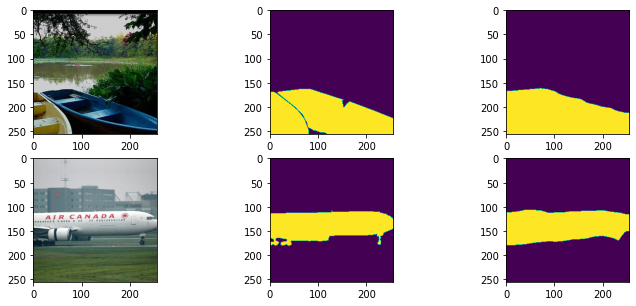

In [79]:
fig,axes = plt.subplots(2, 3, figsize = (12, 5))

for i in [0, 1]:
  im = p1_im[i]
  lb = p1_lb[i]
  pr = p1_pr[i]
  axes[i, 0].imshow(im)
  axes[i, 1].imshow(lb)
  axes[i, 2].imshow(pr)

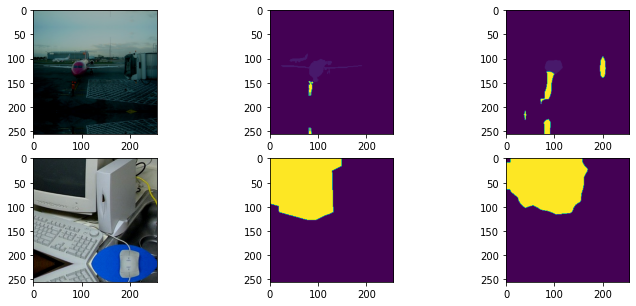

In [80]:
fig,axes = plt.subplots(2, 3, figsize = (12, 5))

for i in [0, 1]:
  im = p2_im[i]
  lb = p2_lb[i]
  pr = p2_pr[i]
  axes[i, 0].imshow(im)
  axes[i, 1].imshow(lb)
  axes[i, 2].imshow(pr)

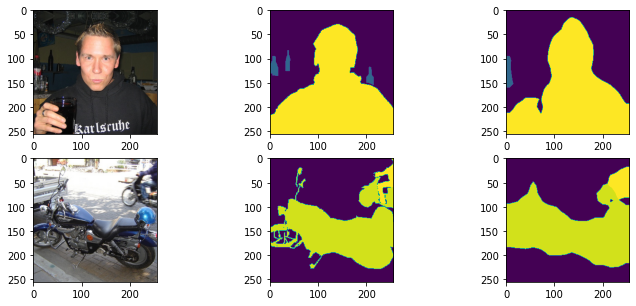

In [81]:
fig,axes = plt.subplots(2, 3, figsize = (12, 5))

for i in [0, 1]:
  im = p3_im[i]
  lb = p3_lb[i]
  pr = p3_pr[i]
  axes[i, 0].imshow(im)
  axes[i, 1].imshow(lb)
  axes[i, 2].imshow(pr)

Лучшая по качеству IoU картинка по трем выбранным классам

In [98]:
class1 = 1
class2 = 5
class3 = 7
pic_im = None
pic_lb = None
pic_pr = None
max_val = [0,0,0]
for i, (img, lbl) in tqdm(enumerate(dataloader1)):
  img = img.cuda()
  lbl = lbl.cuda()
  predict = model(img)['out']
  pr = predict.detach().cpu()
  l = lbl.detach().cpu()
  im = img.detach().cpu()
  m = IoU_batch(l, pr)
  for j, l in enumerate(m):
    if (l[class1] >= max_val[0] and l[class2] >= max_val[1] and l[class3] >= max_val[2]):
      max_val = [l[class1], l[class2], l[class3]]
      pic_im = img[j].detach().cpu().permute(1,2,0)
      pic_lb = np.array(lbl[j].detach().cpu().argmax(0))
      pic_pr = np.array(predict[j].detach().cpu().argmax(0))

183it [14:11,  4.65s/it]


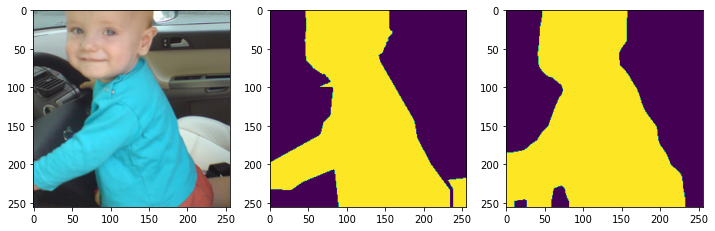

In [99]:
fig,axes = plt.subplots(1, 3, figsize = (12, 5))
axes[0].imshow(pic_im)
axes[1].imshow(pic_lb)
axes[2].imshow(pic_pr)